In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import wfdb

from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

In [4]:
data_dim = 64
timesteps = 10
nb_classes = 2
batch_size = 20

In [5]:
record_path = './data/mitdb/100'

In [6]:
record = wfdb.rdsamp(record_path)
signal = record[0]
annotation = wfdb.rdann(record_path, 'atr')

### Create mask

In [7]:
mask = np.zeros((signal.shape[0], 1))

In [8]:
shift_left = 30
shift_right = 30

In [9]:
for label_id in range(annotation.sample.shape[0]):
    if annotation.symbol[label_id] == 'N' or annotation.symbol[label_id] == 'R':
        for i in range(annotation.sample[label_id]-shift_left, annotation.sample[label_id]+shift_right):
            if i > 0 and i < signal.shape[0]:
                mask[i] = 1

### Create dataset

In [10]:
X = []
y = []
for i in range(timesteps+data_dim, mask.shape[0]):
    sub_sample = []
    for j in range(timesteps):
        sub_sample.append(np.copy(record[0][i-(data_dim+timesteps)+j:i-timesteps+j,0]))
    X.append(np.copy(sub_sample))
    if np.sum(mask[i-(timesteps+data_dim):i][-timesteps:]) > 0:
        y.append([0,1])
    else:
        y.append([1,0])
        
X = np.array(X)
y = np.array(y)

In [11]:
X.shape

(649926, 10, 64)

In [12]:
X = X/np.max(X)

In [13]:
x_train = X[:400000]
x_val = X[400000:]
y_train = y[:400000]
y_val = y[400000:]

In [14]:
x_val.shape

(249926, 10, 64)

In [15]:
x_train.shape

(400000, 10, 64)

### Train model

In [16]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, stateful=True,
               batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(LSTM(32, return_sequences=True, stateful=True))
model.add(LSTM(32, stateful=True))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
x_val = x_val[:240000]

In [18]:
y_val = y_val[:240000]

In [19]:
x_train.shape

(400000, 10, 64)

In [20]:
x_val.shape

(240000, 10, 64)

In [21]:
history = model.fit(x_train, y_train,
          batch_size=batch_size, nb_epoch=3,
          validation_data=(x_val, y_val))

/home/spasenov/venv/science/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 400000 samples, validate on 240000 samples
Epoch 1/3
400000/400000 [==============================] - 777s 2ms/step - loss: 0.0469 - acc: 0.9845 - val_loss: 0.0514 - val_acc: 0.9864
Epoch 2/3
400000/400000 [==============================] - 776s 2ms/step - loss: 0.0361 - acc: 0.9887 - val_loss: 0.0494 - val_acc: 0.9857
Epoch 3/3
400000/400000 [==============================] - 776s 2ms/step - loss: 0.0356 - acc: 0.9891 - val_loss: 0.0593 - val_acc: 0.9838


### Apply model

In [22]:
x_val.shape

(240000, 10, 64)

In [23]:
x_val.shape

(240000, 10, 64)

In [24]:
preds = []

In [25]:
for i in range(0, x_val.shape[0], 20):
    tmp_preds = model.predict(x_val[i:i+20])
    for j in range(20):
        preds.append(tmp_preds[j, 1])

In [26]:
plot_signal = []
for i in range(0, x_val.shape[0]):
    plot_signal.append(x_val[i,-1,-1])

In [27]:
plot_signal = np.array(plot_signal)

In [28]:
preds = np.array(preds)

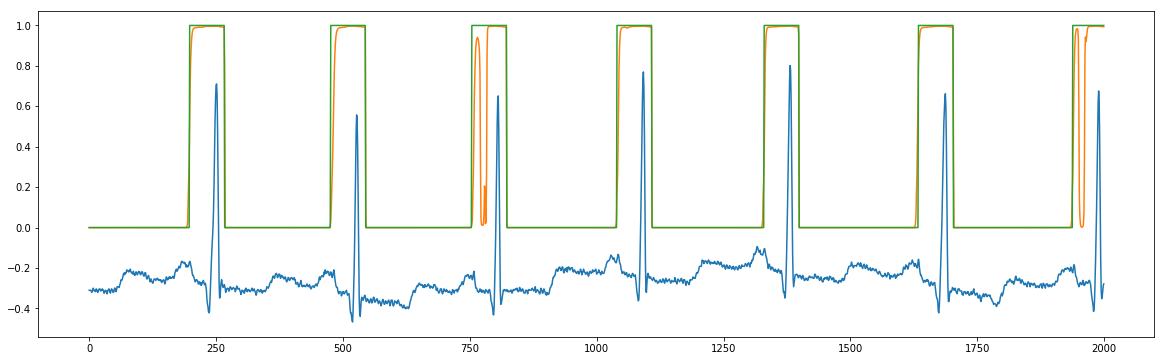

In [29]:
plt.figure(figsize=(20,6))
plt.plot(plot_signal[0:2000])
plt.plot(preds[20:2020])
plt.plot(y_val[:,1][20:2020])
plt.show()